#### **PROGRAMA QUE UTILIZA MACHING LEARNIN PARA CLASIFICAR LOS MANGOS MADUROS Y PODRIDOS**
---


Este programa ilustra el uso de las librerías skimage, pathlib, numpy y matplotlib, para cargar un dataset de imagenes, inspeccionar datos, graficar y corregir errores. El conjunto de datos tomado para este trabajo es de: https://www.kaggle.com/datasets/adrinbd/unripe-ripe-rotten-mango

Este conjunto de datos cuenta con una clasificacion de 3 estados del mango, maduro(ripe), inmaduro(unripe) y podrido(rotten) con sus respectivas imagenes para el entrenamiento del modelo, de este conjunto de datos solo se tendran en cuenta los estados maduros y podridos, se trabajara con las mascaras de los mangos, el proceso para obtener estas mascaras no se tendra en cuneta en este trabajo.

El objetivo de estos conjuntos de imagenes es ser capas de difinir si un mango esta maduro(ripe) o podrido(rotten), usando ese conjunto de imagenes para entrenar este modelo.

In [1]:

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os

from skimage.data import page
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

import pandas as pd
import numpy as np
import skimage as ski
import statistics

from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects




Se creara la función obtener_imagenes(), la cual retornara una lista con donde cada celda contendra un vector con el nombre de la imagen, la imagen a color, la imagen en escala de grises y dejara una posicion disponible para la mascara de cada imagen, dichas mascaras estan en otra carpeta y se agregaran por medio de otra funcion.

In [2]:
def obtener_imagenes(ruta_carpeta):
    """Devuelve una lista de imágenes normales y en escala de grises de la carpeta especificada con el respectivo nombre de la imgen."""
    imagenes = []
    cont = 0
    for archivo in os.listdir(ruta_carpeta):
        try:
            img = ski.io.imread(ruta_carpeta+"/"+archivo)
            img = ski.util.img_as_ubyte(img)
            gray_image = rgb2gray(img)
            imagenes.append([archivo,img,gray_image, ""])
        except Exception as e:
            cont = cont + 1

    return imagenes

La funcion obtener_mask(), recibe como parametro la ruta en la que se encuentran las mascaras y la lista que contiene las imagenes con sus nombres, imagen, imagen en escala de grises y el espacion donde se almacenara la mascara correspondiente, cabe aclarar que las mascaras tienen el mismo nombre que la imagen original agregando mark_ripe o mark_rotten, estos separado por un guion bajo, al final retornara la lista que recibe con el espacio de la mascara lleno con su mascara correspondiente.

In [3]:
def obtener_mask(ruta_carpeta, coleccion):
    """Devuelve una lista de imágenes normales y en escala de grises de la carpeta especificada con el respectivo nombre de la imgen."""
    imagenes = []
    cont = 0
    carpeta = os.listdir(ruta_carpeta)
    for i in coleccion:
        nombre_img = obtener_primera_palabra(i[0],".")
        #print(nombre_img)
        for archivo in carpeta:

            nombre_mask = obtener_primera_palabra(archivo,"_")
            #print(nombre_mask, "y",nombre_img)
            if nombre_img == nombre_mask:
                mask = np.load(ruta_carpeta+"/"+archivo)
                if len(mask.shape) == 3:
                    mask=mask[:,:,1]
                i[3] = mask
                imagenes.append(i)
                break


    return imagenes

La funcion obtener_primera_palabra(),  permite obtener la palabra de una cadena que aparece antes del caracter que recibe por parametro.

In [4]:
def obtener_primera_palabra(palabra, caracter):
    p = palabra.split(caracter)
    return p[0]

La funcion intensity_table(), crea una tabla con el valor de la intensidad de la imagen en escala de grises

In [5]:
def intensity_table(grayValues):
    table = {}
    for ival in range(256):
        table['val_'+ str(ival)] = [np.count_nonzero(grayValues == ival)]

    df_table = pd.DataFrame.from_dict(table, orient='columns')
    return df_table

In [6]:
def hist2features(grayImg, mangoMask):
    #color = ski.util.img_as_ubyte(colorImg)
    gray = ski.util.img_as_ubyte(grayImg)
    #mango_mask = ski.util.invert(mangoMask)
    mango_mask = mangoMask
    
    masked_gray = gray * mango_mask
    plt.imshow(masked_gray, cmap = 'gray')
    plt.show()
    df_intensities = intensity_table(masked_gray)
    print(df_intensities)
    return df_intensities

In [7]:
ripe = obtener_imagenes("./ripe")
rotten = obtener_imagenes("./rotten")


In [8]:
ripe = obtener_mask("./ripe_masks",ripe)
rotten = obtener_mask("./rotten_masks",rotten)

Se busca ver graficamente la cantidad de imagenes que se tienen de los mangos ripe y los mangos rotten.

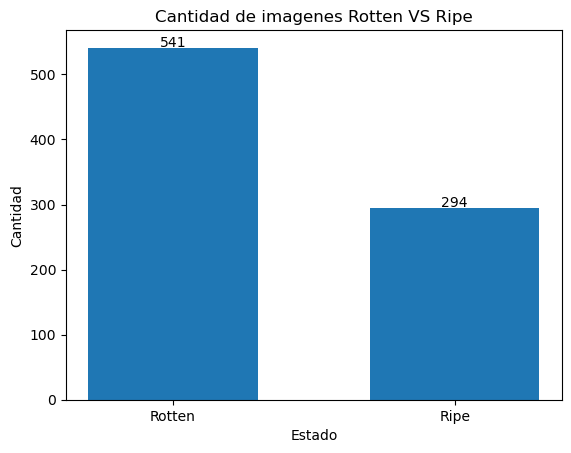

In [9]:
cantidad_imagenes_rotten= len(rotten)
cantidad_imagenes_ripe = len(ripe)

plt.bar(["Rotten", "Ripe"], [cantidad_imagenes_rotten, cantidad_imagenes_ripe], width=0.6)

#mostrar los valores sobre
plt.text(0,cantidad_imagenes_rotten +2, str(cantidad_imagenes_rotten), ha='center')
plt.text(1,cantidad_imagenes_ripe +2, str(cantidad_imagenes_ripe), ha='center')

# Personalizar el gráfico
plt.title('Cantidad de imagenes Rotten VS Ripe')
plt.ylabel('Cantidad')
plt.xlabel('Estado')

# Mostrar el gráfico
plt.show()


# Mostrar el gráfico
plt.show()

Como se ve en la grafica anterior, la cantidad de imagenes, se encuentra desbalanceada a favor de los mangos rotten, teniendo este casi el doble de imagenes de los mangos ripe.

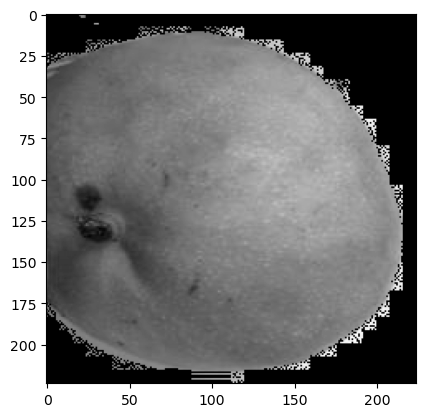

   val_0  val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  ...  \
0  11872      0      1      0      1      0      1      5      3      0  ...   

   val_246  val_247  val_248  val_249  val_250  val_251  val_252  val_253  \
0        0        0        0        0        0        0        0        0   

   val_254  val_255  
0        0        0  

[1 rows x 256 columns]


,val_0,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,...,val_246,val_247,val_248,val_249,val_250,val_251,val_252,val_253,val_254,val_255
0,11872,0,1,0,1,0,1,5,3,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
a =0
imagen2 = rotten[a]
hist2features(imagen2[2],imagen2[3])

In [32]:
def extract_properties(gray_img, mango_mask):

    labeled_mango, count = ski.measure.label(mango_mask, connectivity=2, return_num=True)
    
    object_features = ski.measure.regionprops(labeled_mango)

    var_gris_props = ['area', 'intensity_max', 'intensity_min', 'intensity_mean']
    gris_props = ski.measure.regionprops_table(labeled_mango, gray_img, properties=var_gris_props)
    
    grayImg_stdev = std_image(gray_img, mango_mask)
    df_image = pd.DataFrame(gris_props)
    
    df_image.rename(columns={'intensity_max': 'max_gray_value', 'intensity_min': 'min_gray_value', 'intensity_mean': 'mean_gray_value'}, inplace=True)
    df_image['std'] = grayImg_stdev 
    
    index = df_image['area'].idxmax()

    propiedades = df_image.iloc[[index]]

    return propiedades
    #return df_image

In [12]:
def std_image(gray_img, mango_mask):
    mango_mask = ski.util.invert(mango_mask)
    idx_list = np.where(mango_mask == 1)
    mangoPixel_values = gray_img[idx_list]
    stdev = statistics.stdev(mangoPixel_values)
    return stdev

In [13]:
def normalizar_valores_columna(dataFrame, columna):
    
    min_value = dataFrame[columna].min()
    max_value = dataFrame[columna].max()
    # Aplicar normalización
    valor_normalizado = (dataFrame[columna] - min_value) / (max_value - min_value)
    dataFrame[columna] = valor_normalizado
    return dataFrame



In [14]:
def obtener_data_frame_imagenes(lista_imagenes):
    df = extract_properties(lista_imagenes[0][2],lista_imagenes[0][3])
    cont = 1
    for imagen in lista_imagenes[1:]:
        try:
            df_ciclo = extract_properties(imagen[2],imagen[3])
            df =  pd.concat([df, df_ciclo], ignore_index=True)
            cont = cont + 1
        except Exception as e:
            print(f"Se produjo un error inesperado: {e}")
            print(cont)
        
    return df

In [24]:
extract_properties(imagen2[2],imagen2[3])

,area,max_gray_value,min_gray_value,mean_gray_value,std
0,18.0,0.515893,0.406915,0.465691,0.154488
1,3.0,0.591258,0.528513,0.565114,0.154488
2,38239.0,0.895004,0.009167,0.434802,0.154488
3,5.0,0.506145,0.360505,0.423691,0.154488
4,1.0,0.485705,0.485705,0.485705,0.154488
5,4.0,0.447058,0.433328,0.439778,0.154488
6,3.0,0.635802,0.547785,0.606463,0.154488
7,2.0,0.415595,0.409434,0.412515,0.154488
8,1.0,0.497965,0.497965,0.497965,0.154488
9,1.0,0.577199,0.577199,0.577199,0.154488


In [33]:
df_ripe = obtener_data_frame_imagenes(ripe)
df_ripe.tail()

,area,max_gray_value,min_gray_value,mean_gray_value,std
289,13767.0,0.764513,0.105748,0.396082,0.116050
290,8045.0,0.602485,0.067388,0.387897,0.031983
291,9706.0,0.652587,0.073274,0.377345,0.039939
292,11870.0,0.728333,0.088693,0.398226,0.068697
293,13666.0,0.682874,0.039722,0.419652,0.043466


In [34]:
df_rotten = obtener_data_frame_imagenes(rotten)
df_rotten.tail()
#error con la mascara 480, su tamaño es (219, 223) mientra que la imagen en gris es de (224, 224), por eso no deja multiplicar

Se produjo un error inesperado: Label and intensity image shapes must match, except for channel (last) axis.
480


,area,max_gray_value,min_gray_value,mean_gray_value,std
535,30213.0,1.000000,0.006667,0.372301,0.088876
536,37362.0,0.941258,0.004167,0.553169,0.279407
537,31724.0,0.897565,0.005833,0.411765,0.159261
538,32777.0,1.000000,0.024167,0.517712,0.037552
539,17131.0,1.000000,0.010878,0.458615,0.022709


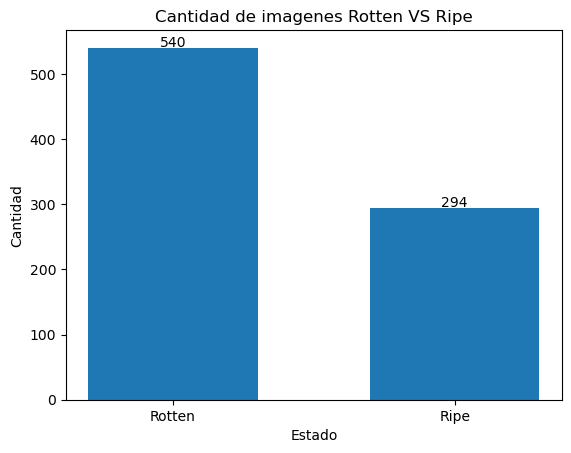

In [35]:
cantidad_imagenes_rotten= df_rotten.shape[0]
cantidad_imagenes_ripe = df_ripe.shape[0]

plt.bar(["Rotten", "Ripe"], [cantidad_imagenes_rotten, cantidad_imagenes_ripe], width=0.6)

#mostrar los valores sobre
plt.text(0,cantidad_imagenes_rotten +2, str(cantidad_imagenes_rotten), ha='center')
plt.text(1,cantidad_imagenes_ripe +2, str(cantidad_imagenes_ripe), ha='center')

# Personalizar el gráfico
plt.title('Cantidad de imagenes Rotten VS Ripe')
plt.ylabel('Cantidad')
plt.xlabel('Estado')

# Mostrar el gráfico
plt.show()


In [85]:
df_combinado = pd.concat([df_ripe, df_rotten], ignore_index=True)
# Creamos una nueva columna 'clase' y asignamos los valores
df_combinado['clase'] = False
df_combinado.loc[df_combinado.index >= len(df_ripe), 'clase'] = True
df_combinado = normalizar_valores_columna(df_combinado,"area")
df_combinado.head()

,area,max_gray_value,min_gray_value,mean_gray_value,std,clase
0,0.002727,0.657422,0.096415,0.445445,0.109363,False
1,0.002006,0.675431,0.072455,0.408536,0.059956,False
2,0.009000,0.671715,0.106655,0.475659,0.051618,False
3,0.007012,0.615909,0.064277,0.363080,0.029167,False
4,0.002696,0.593028,0.060416,0.363767,0.034493,False


In [86]:
df_combinado.tail()

,area,max_gray_value,min_gray_value,mean_gray_value,std,clase
829,0.041444,1.000000,0.006667,0.372301,0.088876,True
830,0.052233,0.941258,0.004167,0.553169,0.279407,True
831,0.043724,0.897565,0.005833,0.411765,0.159261,True
832,0.045313,1.000000,0.024167,0.517712,0.037552,True
833,0.021700,1.000000,0.010878,0.458615,0.022709,True


In [87]:
df_combinado.dtypes
df_combinado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             834 non-null    float64
 1   max_gray_value   834 non-null    float64
 2   min_gray_value   834 non-null    float64
 3   mean_gray_value  834 non-null    float64
 4   std              834 non-null    float64
 5   clase            834 non-null    bool   
dtypes: bool(1), float64(5)
memory usage: 33.5 KB


<Axes: >

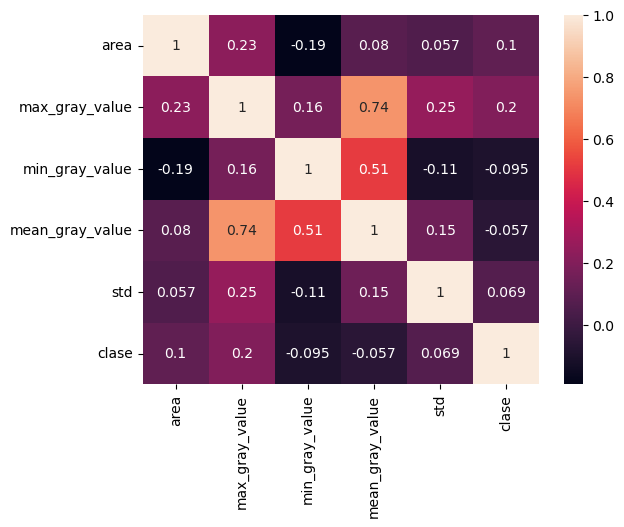

In [88]:

# Crear el mapa de calor
sns.heatmap(df_combinado.corr(), annot=True)

<Axes: >

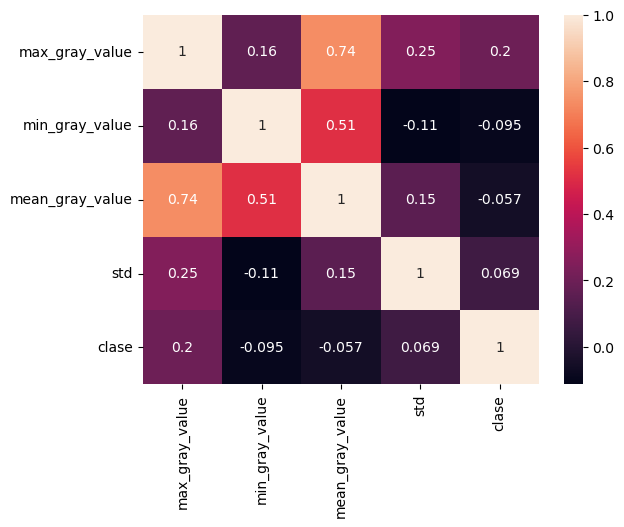

In [81]:
df_combinado.drop('area', axis=1 , inplace=True)
sns.heatmap(df_combinado.corr(), annot=True)